## Summary
DisCoPy is a python toolkit for computing with string diagrams.

For more information, see:
- The [discopy website](https://discopy.org)
- The [documentation](https://docs.discopy.org/en/main/index.html)

While it is a very general library for drawing various types of diagrams, one feature is constructing quantum circuits, and evaluating them using the built-in `eval()` function. The evaluation can be done exactly (including support for discarding and post-selection) and also has support for `pytket` backends. This is not a discopy tutorial, just an introduction to using it to run quantum circuits. See the documentation for more information on how to construct circuits.

**ALL THE THINGS ABOUT THE VARIOUS THINGS .eval() CAN RETURN FOR A MIXED STATE NEED CHECKING**

## Imports for circuit construction

In [54]:
from discopy.quantum import qubit, Bra, Ket, H, CX, Id, Measure, Discard
import numpy as np

## Construct a circuit by composing boxes

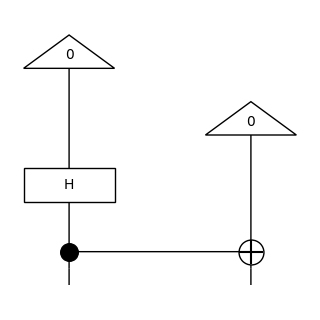

In [9]:
base_circuit = Ket(0) @ Ket(0) >> H @ Id(qubit) >> CX
base_circuit.draw(figsize=(3,3))

## Evaluating the circuit

The circuit currently has open wires (the diagram is read top to bottom). This means it represents a 2-qubit state with a statevector of $2^2 = 4$ dimensions. If we call `.eval()` on this circuit directly, we get its _statevector_.

In [10]:
a = base_circuit.eval()
a

Tensor[complex]([0.70710678+0.j, 0.    +0.j, 0.    +0.j, 0.70710678+0.j], dom=Dim(1), cod=Dim(2, 2))

Now let's add a discard onto one of the wires:

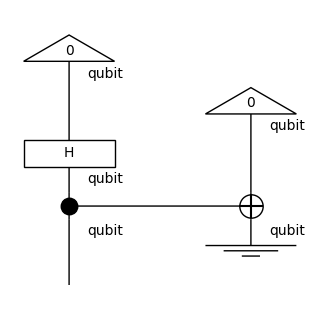

In [11]:
discard_circuit = base_circuit >> Id(qubit) @ Discard()
discard_circuit.draw(figsize=(3,3))

This now represents a mixed state, and we get a channel out as a result.

In [12]:
a = discard_circuit.eval()
a

Channel([0.5+0.j, 0. +0.j, 0. +0.j, 0.5+0.j], dom=CQ(), cod=Q(Dim(2)))

If instead we postselect (i.e. add a bra onto the bottom of one of the wires) and leave the first wire open, we get the statevector of the remaining qubit. This needs to be normalised, however.

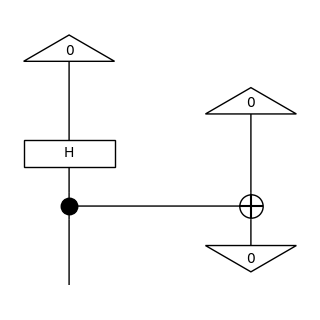

In [50]:
postselect0_circuit = base_circuit >> Id(qubit) @ Bra(0)
postselect0_circuit.draw(figsize=(3,3))

In [57]:
state = postselect0_circuit.eval().array
print('Returned state: ', state)
normalised_state = state / np.linalg.norm(state)
print('Normalised state: ', normalised_state)

Returned state:  [0.70710678+0.j 0.        +0.j]
Normalised state:  [1.+0.j 0.+0.j]


Instead, we can measure the first qubit rather than leaving it open. In this case we get the (un-normalised) probability of getting 0 or 1 on the measured wire.

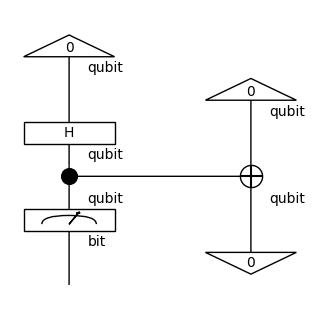

In [61]:
postselect0_measure_circuit = base_circuit >> Measure() @ Bra(0)
postselect0_measure_circuit.draw(figsize=(3,3))

In [62]:
prob = postselect0_measure_circuit.eval().array
print("Returned prob: ", prob)
normalised_prob = prob / np.sum(prob)
print("Normalised prob: ", normalised_prob)

Returned prob:  [0.5+0.j 0. +0.j]
Normalised prob:  [1.+0.j 0.+0.j]


## Using a backend with `.eval()`

You can pass a tket-style backend to discopy's `.eval()` to execute on a device or simulator. You still call `.eval()` directly on the circuit, but you need to pass the backend, and you will need to ask for the circuit to be compiled using `compile=backend.default_compilation_pass(2)` (this is explained further in the [pytket compilation docs](https://cqcl.github.io/pytket/manual/manual_compiler.html)). 

Detail on using `.eval()` with circuits can be found in the [discopy docs](https://docs.discopy.org/en/main/_api/discopy.quantum.circuit.Circuit.html?highlight=eval#discopy.quantum.circuit.Circuit.eval).

In [63]:
from pytket.extensions.qiskit import AerBackend

backend = AerBackend()

measure_circuit = base_circuit >> Measure() @ Measure()

As we have given a circuit with measurements, the output is the probabilities of the various bitstrings -- as we have a bell state here, we should get a 50/50 split between $|00\rangle$ and $|11\rangle$ (although because we are using Aer we will get a small amount of noise).

In [64]:
measure_circuit.eval(backend=backend, compile=backend.default_compilation_pass(2), n_shots=1000)

Tensor[complex]([0.496+0.j, 0.  +0.j, 0.  +0.j, 0.504+0.j], dom=Dim(1), cod=Dim(2, 2))

### Postselection on backends

Discopy also allows for post-selection.

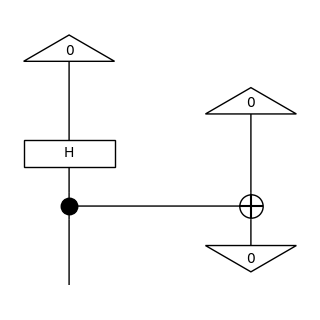

In [65]:
postselect_circuit = base_circuit >> Id(qubit) @ Bra(0)
postselect_circuit.draw(figsize=(3,3))

In [67]:
state = postselect_circuit.eval().array
print('Returned state: ', state)
normalised_state = state / np.linalg.norm(state)
print('Normalised state: ', normalised_state)

Returned state:  [0.70710678+0.j 0.        +0.j]
Normalised state:  [1.+0.j 0.+0.j]


As before, we can put a measurement into the open wire instead.

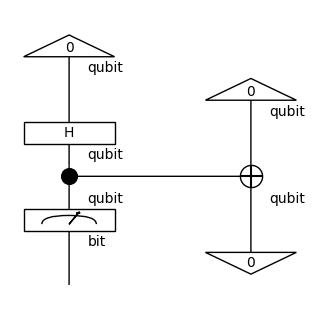

In [69]:
postselect0_measure_circuit = base_circuit >> Measure() @ Bra(0)
postselect0_measure_circuit.draw(figsize=(3,3))

In [70]:
prob = postselect0_measure_circuit.eval().array
print("Returned prob: ", prob)
normalised_prob = prob / np.sum(prob)
print("Normalised prob: ", normalised_prob)

Returned prob:  [0.5+0.j 0. +0.j]
Normalised prob:  [1.+0.j 0.+0.j]
